## Установка необходимых библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python-dotenv==0.19.0 tqdm==4.62.2 numpy Pillow==7.0.0 matplotlib==3.4.3 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 matplotlib
!pip install scikit-learn==0.24.2 torch==1.12.1 torchvision==0.13.1 pytorch-ignite segmentation-models-pytorch==0.2.0 albumentations==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.8 MB/s 
     |████████████████████████████████| 2.1 MB 29.6 MB/s 
     |████████████████████████████████| 10.3 MB 37.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 7.0.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 264 kB 39.0 MB/s 
     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 98 kB 7.6 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 376 kB 61.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12422 sha256=4da03d2ce9d76897b1850558ad50b751911707e966b60476532bdde4da8db540
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=9a90fbb4a7ae439caf2585fdfbe258d088631c178c13db7ce3f42603624bc859
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f48

In [ ]:
## Импорт необходимых библиотек
import torch
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Metric
from ignite.engine import _prepare_batch

from tqdm import tqdm

import json
import base64
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Dict, Any, List, Sequence, Iterator, Optional
from collections import defaultdict
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

from ipywidgets import IntProgress
from IPython.display import display
import time

## Сегментация дверей и окон

### Вспомогательные функции

In [ ]:
## PLRC DATASET - класс и необходимые функции для датасета

def get_color_map():
    return {
        #"wall": 255,
        "window": 255
    }

def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image


def tensor_from_mask_image(mask: np.ndarray) -> torch.Tensor:
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, -1)
    return tensor_from_rgb_image(mask)


class PLRCDataset(Dataset):
    def __init__(self, image_folder, transform, start_index, end_index, mask_folder=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        self.images = PLRCDataset.parse_folder(self.image_folder, start_index, end_index)
        self.color_map = get_color_map()

    @staticmethod
    def parse_folder(path, start, end):
        if path is None:
            return []
        images = glob.glob1(path,  '*.png')
        images.sort()

        return images[start:end]

    @staticmethod
    def load_image(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def load_mask(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def split_grayscale_mask_into_channels_by_color_map(mask, color_map) -> torch.Tensor:
        masks = []

        for i in color_map.values():
            masks.append(mask == i)

        return torch.cat(masks).float()

    def mask_to_grayscale(self, masks) -> np.ndarray:
        masks = masks.cpu().numpy()

        colors_by_index = list(self.color_map.values())
        img = np.zeros(masks.shape[1:], dtype=np.uint8)

        for i in range(len(masks)):
            img[masks[i] == 1] = colors_by_index[i]

        return img

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_folder, image_name)

        image = PLRCDataset.load_image(image_path)

        if self.mask_folder is None:
            # sample = self.transform(image=image)
            # image = sample['image']
            return image_name, tensor_from_mask_image(image).float() / 255.0

        mask_path = os.path.join(self.mask_folder, image_name)
        mask = PLRCDataset.load_mask(mask_path)

        sample = self.transform(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

        image = tensor_from_mask_image(image)
        image = torch.cat([image, image, image])
        mask = tensor_from_mask_image(mask)

        mask = PLRCDataset.split_grayscale_mask_into_channels_by_color_map(mask, self.color_map)

        return image.float() / 255.0, mask

    def __len__(self):
        return len(self.images)


## PLRC UTILS = утилиты для подсчета


def get_training_augmentation():
    return A.Compose([
        # A.RandomCrop(height=256, width=256, p=1),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        A.VerticalFlip(p=1),              
        A.RandomRotate90(p=1)
    ], p=1)


def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)


def get_data_loader(path, batch_size, n_processes, start_index, end_index, shuffle=True):
    image_path = os.path.join(path, 'image')
    mask_path = os.path.join(path, 'mask')

    dataset = PLRCDataset(image_folder=image_path, mask_folder=mask_path, transform=get_training_augmentation(), 
                          start_index=start_index, end_index=end_index)

    return DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, num_workers=n_processes, shuffle=shuffle)


def get_train_validation_data_loaders(path, batch_size, n_processes, train_split):
    files_count = len(os.listdir(os.path.join(path, 'image')))

    train_dl = get_data_loader(path, batch_size, n_processes, shuffle=True, start_index=0, end_index=int(files_count*train_split))
    test_dl = get_data_loader(path, batch_size, n_processes, shuffle=False, start_index=int(
        files_count*train_split), end_index=(files_count-1))

    return train_dl, test_dl


## DATA LOSS - функции для подсчета метрик качества обучения нейросетей

class BCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight

    @staticmethod
    def soft_dice(predict, target):
        eps = 1e-15
        batch_size = target.size()[0]

        dice_target = (target == 1).float().view(batch_size, -1)
        dice_predict = torch.sigmoid(predict).view(batch_size, -1)

        inter = torch.sum(dice_predict * dice_target) / batch_size
        union = (torch.sum(dice_predict) + torch.sum(dice_target)) / batch_size + eps

        return (2 * inter.float() + eps) / union.float()

    def __call__(self, predict, target):
        loss = (1.0 - self.dice_weight) * self.nll_loss(predict, target)

        if self.dice_weight:
            loss -= self.dice_weight * torch.log(BCESoftDiceLoss.soft_dice(predict, target))

        return loss


class MultiClassBCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.bce_soft_dice = BCESoftDiceLoss(dice_weight)

    def __call__(self, predict, target):
        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += self.bce_soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        return loss[0] / float(classes)


class MultiClassSoftDiceMetric(Metric):
    def __init__(self):
        super(MultiClassSoftDiceMetric, self).__init__()
        self.general_loss = 0

    def reset(self):
        self.general_loss = 0

    def update(self, output):
        predict, target = output

        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += BCESoftDiceLoss.soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        self.general_loss = loss[0] / float(classes)

    def compute(self):
        return self.general_loss



## Функции для обучения

def load_trained_model(model, optimizer, model_path, optimizer_path):
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    print('Load model from: ', model_path)
    print('Load optimizer from: ', optimizer_path)


def save_model(model, optimizer, model_path, optimizer_path, postfix='_'):
    torch.save(model.state_dict(), model_path + postfix)
    torch.save(optimizer.state_dict(), optimizer_path + postfix)


def log_image(image, prefix, epoch, step):
    img = Image.fromarray(image)
    image_name = "%s_%s_%s.png" % (epoch, step, prefix)
    img.save(image_name)

    os.remove(image_name)


def run_test_model(model, evaluate_loader, epoch, device, step=10):
    model.eval()
    count_step = 0

    for idx, batch in enumerate(evaluate_loader):
        if count_step > step:
            break

        x, y = _prepare_batch(batch, device)

        predict = model(x)
        predict = torch.sigmoid(predict) > 0.2

        count_step += len(x)

    model.train()


def run_train(dataset_path, batch_size, n_processes, model_path, optimizer_path, load_pre_model=False,
              device='cpu', lr=0.0001, betas=(0.9, 0.99), weight_decay=0.0004, epochs=10,
              log_interval=20, save_interval=2, train_split=0.85):

    train_loader, evaluate_loader = get_train_validation_data_loaders(path=dataset_path, batch_size=batch_size,
                                                                      n_processes=n_processes, train_split=train_split)
    model = smp.FPN('resnet50', classes=24)

    if device.startswith('cuda'):
        if not torch.cuda.is_available():
            raise ValueError('CUDA is not available')

        model = model.to(device)
        print('CUDA is used')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

    if load_pre_model:
        load_trained_model(model, optimizer, model_path, optimizer_path)

    trainer = create_supervised_trainer(model, optimizer, MultiClassBCESoftDiceLoss(0.7), device=device)
    evaluator = create_supervised_evaluator(model,
                                            metrics={'dice': MultiClassSoftDiceMetric(),
                                                     'nll': Loss(MultiClassBCESoftDiceLoss(0.7))},
                                            device=device)

    desc = "ITERATION - loss: {:.2f}"
    pbar = None

    @trainer.on(Events.EPOCH_STARTED)
    def create_pbar(engine):
        model.train()
        nonlocal pbar
        pbar = tqdm(
            initial=0, leave=False, total=len(train_loader),
            desc=desc.format(0)
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        pbar.close()
        evaluator.run(evaluate_loader)
        metrics = evaluator.state.metrics
        avg_dice = metrics['dice']
        avg_nll = metrics['nll']


        print("Training Results - Epoch: {}  Dice: {:.2f} Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_dice, avg_nll))

        if engine.state.epoch % save_interval == 0:
            save_model(model, optimizer, model_path, optimizer_path, '_' + list(get_color_map().keys())[0]) #str(engine.state.epoch))
            run_test_model(model, evaluate_loader, engine.state.epoch, device)

    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):

        pbar.desc = desc.format(engine.state.output)
        pbar.update()


    model.train()

    trainer.run(train_loader, max_epochs=epochs)

In [ ]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [ ]:
## Необходимые вспомогательные функции
def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)

def mask_to_grayscale(masks) -> np.ndarray:
    masks = masks.cpu().numpy()

    img = np.zeros(masks.shape[1:], dtype=np.uint8)

    img[masks[0] == 1] = 255

    return img

def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image

def convert_image(img):
    if img is None:
        return
    height, width, channels = img.shape
    rect = (0, 0, 512, 512)
    h = rect[3]
    w = int(h * width / height)
    if w > rect[2]:
        w = rect[2]
        h = int(height / width * w)
    new_img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
    s = np.full((rect[3], rect[2], 3), np.uint8(255))
    sy = int((rect[3] - h) / 2)
    sx = int((rect[2] - w) / 2)
    s[sy:sy + h, sx:sx + w] = new_img
    return s


In [ ]:
def get_color_map():
    return {
        "wall": 255,
        "window": 255
    }

## Детекция дверей

### Вспомогательные функции

#### Инициализация модели обучения и функций для подсчета метрик качества обучения нейросетей

In [ ]:
def initialize_model(num_classes: int,
                     min_size: int, max_size: int,
                     image_mean: Sequence[float], image_std: Sequence[float],
                     device: str = None) -> torch.nn.Module:
    pretrained_model = fasterrcnn_resnet50_fpn(pretrained=False, min_size=min_size, max_size=max_size,
                                               image_mean=image_mean, image_std=image_std)
    num_predictor_features = pretrained_model.roi_heads.box_head.fc7.out_features
    pretrained_model.roi_heads.box_predictor = FastRCNNPredictor(num_predictor_features, num_classes)

    return pretrained_model.to(device)


def compute_iou(box1: torch.tensor, box2: torch.tensor) -> torch.tensor:
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])

    if x2 - x1 < 0 or y2 - y1 < 0:
        return 0

    intersection = (x2 - x1) * (y2 - y1)
    sum_ = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (box2[2] - box2[0]) * (box2[3] - box2[1]))

    iou = intersection / (sum_ - intersection)

    return iou.item()


class MeanAveragePrecision:

    def __init__(self, num_conf: int = 11):
        self.num_conf = num_conf

    @staticmethod
    def is_true(box: torch.tensor, label: int,
                y_true: Dict[str, torch.tensor],
                iou_thresh: float = 0.5) -> bool:
        num_true = len(y_true['boxes'])

        for i in range(num_true):
            if label == y_true['labels'][i]:
                if compute_iou(box, y_true['boxes'][i]) > iou_thresh:
                    return True
        return False

    @staticmethod
    def compute_map_given_conf(y_preds: List[Dict[str, torch.tensor]],
                               y_trues: List[Dict[str, torch.tensor]],
                               conf: float) -> float:
        num_pos = defaultdict(int)
        num_true_pos = defaultdict(int)

        for y_pred, y_true in zip(y_preds, y_trues):

            num_pred = len(y_pred['boxes'])

            for i in range(num_pred):
                if y_pred['scores'][i] > conf:
                    label = y_pred['labels'][i]
                    num_pos[label] += 1

                    if MeanAveragePrecision.is_true(y_pred['boxes'][i], y_pred['labels'][i], y_true):
                        num_true_pos[label] += 1

        all_classes_sum = sum(num_true_pos[lbl] / num_pos[lbl] for lbl in num_pos)

        try:
            precision = all_classes_sum / len(num_pos)
        except ZeroDivisionError:
            precision = 0

        return precision

    def __call__(self, y_pred: List[Dict[str, torch.tensor]],
                 y_true: List[Dict[str, torch.tensor]]) -> float:
        assert len(y_pred) == len(y_true)

        map_sum = 0

        for conf in np.linspace(0, 1, self.num_conf):
            map_sum += self.compute_map_given_conf(y_pred, y_true, conf)

        return torch.tensor(map_sum / self.num_conf)


def minimum_bounding_box(points: List[List[float]]) -> Tuple[float, float, float, float]:
    x_min = min(p[0] for p in points)
    y_min = min(p[1] for p in points)
    x_max = max(p[0] for p in points)
    y_max = max(p[1] for p in points)

    return x_min, y_min, x_max, y_max


#### Объявляем конфиг для object_detection

In [ ]:
config = {
  "dataset_path": "train/object_detection",
  "model_log_interval": 1,
  "data": {
    "class_ids": {
      "door": 1,
      "door_balcony": 1
    }
  },
  "model": {
    "image_size": 512
  },
  "training": {
    "num_epochs": 2,
    "batch_size": 16,
    "update_every_n_batches": 1,
    "device": "cpu",
    "learning_rate": 1e-4,
    "num_workers": 0
  }
}

## Сборка результата сегментации и детекции

In [ ]:
def draw_pred_with_boxes(image: np.ndarray, 
                         preds: Dict[str, np.ndarray] = None):

    image = image.copy()

    num_boxes = len(preds['boxes'])

    for i in range(num_boxes):
        x_min, y_min, x_max, y_max = preds['boxes'][i]

        cv2.rectangle(img=image,
                      pt1=(int(x_min), int(y_min)),
                      pt2=(int(x_max), int(y_max)),
                      color=3,
                      thickness=-1)

    return image

In [ ]:
folder_dir = '/content/drive/MyDrive/experiment/'
transform = get_test_augmentation()

# Загрузка модели сегментации окон
model_window = smp.FPN(encoder_name='resnet50', classes=24)
model_window.load_state_dict(torch.load("/content/drive/MyDrive/model/first_model/model_window_1", map_location=torch.device('cpu')))
model_window.eval()

# Загрузка модели сегментации стен
model_wall = smp.FPN(encoder_name='resnet50', classes=24)
model_wall.load_state_dict(torch.load("/content/drive/MyDrive/model/first_model/model_wall_1", map_location=torch.device('cpu')))
model_wall.eval()

# Загрузка модели детекции дверей
model_door = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
model_door.load_state_dict(torch.load("/content/drive/MyDrive/model/model_obj_door_1",  map_location=torch.device('cpu')))
class_ids = config['data']['class_ids']
reverse_classes_map = {v: k for k, v in class_ids.items()}
transform_door = ToTensorV2()
model_door.eval()

# Прогресс
prgBar = IntProgress(min = 0, max = len(os.listdir(folder_dir))) # Создаем прогрессбар
display(prgBar) # Выводим прогрессбар на экран

for images in os.listdir(folder_dir):
    ##Загрузка тестового изображения
    image = cv2.imread(folder_dir+images)
    converted_image = convert_image(image)

    ## Применение сегментации
   
    image = transform(image=converted_image)['image']
    image = tensor_from_rgb_image(image)
    image = image.view((1, 3, image.shape[1], image.shape[2]))

    ## Получение предсказания по тестовому изображениям
    with torch.no_grad():
        predict_window = model_window(image)
        predict_wall = model_wall(image)

    predict_window = torch.sigmoid(predict_window) > 0.2
    window = mask_to_grayscale(predict_window[0])

    predict_wall = torch.sigmoid(predict_wall) > 0.2
    wall = mask_to_grayscale(predict_wall[0])

    ## Объединение масок и установка класса (1-стены, 2-окна, 3-двери)
    wall[np.where(wall == 255)] = 1
    wall[np.where(window == 255)] = 2
    

    ## Детекция дверей
    image = cv2.imread(folder_dir+images).astype(np.float32) / 255
    bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
    x = image
    x = transform_door(image=x)['image']
    with torch.no_grad():
        y_pred = model_door([torch.tensor(x, device=config['training']['device'])])[0]
        y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
        y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

    ## Возвращение оригинального размера изображения
    result_img = cv2.resize(wall, (cv2.imread(folder_dir+images).shape[1], cv2.imread(folder_dir+images).shape[0]))

    ## Объединение сегментации и детекции
    result_img = draw_pred_with_boxes(result_img, y_pred)

    ## Сохранение файла
    cv2.imwrite("/content/drive/MyDrive/test_result/" + images, result_img)

    ## Прогресс
    prgBar.value = prgBar.value + 1 # Двигаем "полоску"

IntProgress(value=0, max=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(850, 800)

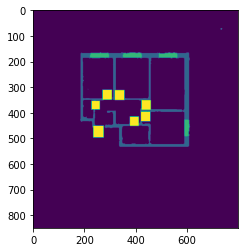

In [ ]:
x = cv2.imread('/content/drive/MyDrive/test_result/test.png', 0)
plt.imshow(x)
x.shape